In [ ]:
import os
import io
from imgsize import get_size
import json
from tqdm import tqdm

from glob import glob
import matplotlib.pyplot as plt
import cv2

##### yolo data format을 위한 이미지 정보를 json파일에 저장

In [ ]:

def convert_yolo_format(json_file, imgdir) :
    with open(json_file, 'r') as f :
        json_info = json.load(f)
    
    yolo_json_info = []

    for info in tqdm(json_info) :
        imgfile = os.path.join(imgdir, info['name'])

        with io.open(imgfile, 'rb') as fobj :
            width, height = get_size(fobj)

        info['imgsize'] = [height, width]

        
        label_info = info['labels'] if 'labels' in info.keys() else []

        for idx in range(len(label_info)) :
            # try :
            label = label_info[idx]['category']
            coord = label_info[idx]['box2d']
            # except :
            #     print(label_info[idx])
            #     raise
            xmin, xmax = coord['x1'], coord['x2']
            ymin, ymax = coord['y1'], coord['y2']

            w = xmax - xmin
            h = ymax - ymin

            x_center = xmin + w / 2
            y_center = ymin + h / 2

            w /= width # normalize 0-1
            h /= height

            x_center /= width
            y_center /= height



            info['labels'][idx]['box2d'] = { 'x' : round(float(x_center), 4),
                                             'y' : round(float(y_center), 4),
                                             'w' : round(float(w), 4),
                                             'h' : round(float(h), 4)
                                                }

        yolo_json_info.append(info)

    return yolo_json_info

def save_json_info(json_info, savename) :
    with open(savename, 'w') as f :
        json.dump(json_info, f, indent = 4)

In [ ]:
json_file = 'data/label/det_val.json'
imgdir = 'data/images/val'

val_yolo_json_info = convert_yolo_format(json_file, imgdir)

In [ ]:
save_json_info(val_yolo_json_info, 'data/label/yolo_det_val.json')

In [ ]:
json_file = 'data/label/det_train.json'
imgdir = 'data/images/train'

train_yolo_json_info = convert_yolo_format(json_file, imgdir)

In [ ]:
save_json_info(train_yolo_json_info, 'data/label/yolo_det_train.json')

In [ ]:
def read_json_info(jsonfile) :
    with open(jsonfile, 'r') as f :
        json_infos = json.load(f)

    for js_info in tqdm(json_infos) :
        img_h, img_w = js_info['imgsize']
        label_info = js_info['labels'] if 'labels' in js_info.keys() else []
        for idx in range(len(label_info)) :
            label = label_info[idx]['category']
            coord = label_info[idx]['box2d']

            x,y,w,h = coord['x'], coord['y'], coord['w'], coord['h']
            if 0 <= x <= img_w and 0 <= y <= img_h :
                continue
            else :
                raise ValueError(f"{js_info['name'], {x,y,w,h}}")



In [ ]:
read_json_info('data/label/yolo_det_train.json')

#### Image Resize

In [ ]:

val_imgfiles = sorted(glob('data/images/val/*.jpg'))

with open('data/label/yolo_det_val.json', 'r') as f :
    val_json = json.load(f)

val_json = sorted(val_json, key = lambda x : x['name'])


In [ ]:
import albumentations as A

transform = A.Compose([
    A.geometric.resize.SmallestMaxSize(max_size = 446),
    A.RandomCrop(width = 446, height = 446),
], bbox_params = A.BboxParams(format = 'yolo', label_fields = ['label'], min_visibility = 0.1))



In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    img_h, img_w = img.shape[:2]

    x, y, w, h = bbox
    x_min, x_max, y_min, y_max = x - w, x + w, y - w, y + w
    x_min = int(img_w * x_min)
    x_max = int(img_w * x_max)
    y_min = int(img_h * y_min)
    y_max = int(img_h * y_max)



   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
idx = 550
img = plt.imread(val_imgfiles[idx])
bboxes, labels = zip(*[([l['box2d']['x'], l['box2d']['y'], l['box2d']['w'], l['box2d']['h']], l['category']) \
            for l in val_json[idx]['labels']])



### Visualize DataModule 

In [1]:
from YOLOv1.data import BDDDataModule
import albumentations as A
import albumentations.pytorch as pytorch
from global_utils import visualize_gridbbox
import matplotlib.pyplot as plt

imgdir = 'data/images/val'
jsonfile = 'data/label/det_val.json'
num_grid = 7
num_classes = 13
numbox = 2
batch_size = 1
num_workers = 0

train_transform = A.Compose(
    [
        A.geometric.resize.RandomScale(scale_limit=0.2),
        A.geometric.transforms.Affine(translate_percent = [0.2, 0.2]), 
        A.geometric.resize.SmallestMaxSize(max_size=446),
        A.Normalize(),  # mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        A.transforms.ColorJitter(brightness = 0.5, saturation = 0.5), 
        A.RandomCrop(width=446, height=446, always_apply=True, p=1.0),
        A.PadIfNeeded(min_width=446 , min_height=446, border_mode=None),
        
        pytorch.transforms.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc", label_fields=["label"], min_visibility=0.8 # bounding box will be changed into yolo format after the encoding
    ),
)

test_transform = A.Compose(
    [
        A.Normalize(), # mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        A.geometric.resize.LongestMaxSize(max_size=446),
        A.PadIfNeeded(min_width=446, min_height=446, border_mode=None),
         
        pytorch.transforms.ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc", label_fields=["label"], min_visibility=0.8
    ),
)



datamodule = BDDDataModule(imgdir, jsonfile, num_grid, num_classes, numbox, batch_size, num_workers, train_transform = train_transform, test_transform = test_transform,)

datamodule.setup('fit')
datamodule.setup('test')

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2800.0_x64__qbz5n2kfra8p0\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: encv-python is an invalid version and will not be supported in a future release
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\distributed\_shard\partial_tensor.py:40: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\distributed\_shard\replicated_tensor.py:20: UserWarning: Please use DTensor instead and we are deprecating ShardedTensor.
  warnings.warn(DEPRECATE_MSG)
validate json and image matching...: 10000it [00:00, 606262.23it/s]
validate json and image matching...: 10000it [00:00, 581468.12it/s

In [2]:
train_dataloader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

In [3]:
train_img_batch, train_label_grid_batch, train_bbox_batch, train_label_batch = next(iter(train_dataloader))
test_img_batch, test_label_grid_batch, test_bbox_batch, test_label_batch = next(iter(test_dataloader))

bboxes :  [(4.559890730468737, 195.86217481666668, 41.66497654453127, 231.41623246944442), (365.56145513203137, 283.20149193055556, 385.6600426101562, 300.9785210666667), (275.8908303585937, 277.0181770444444, 295.98941845624995, 284.7473198777778), (309.90382703046873, 282.4285770277778, 315.31498519765614, 292.47646333055553), (259.6573564765624, 272.3806913444445, 265.8415372390625, 285.52023478055554), (67.94774602421876, 268.5161199277778, 75.67797197734376, 279.3369205138889), (39.345908758593794, 267.74320564444446, 63.309610452343755, 276.2452627611111), (8.425004326562487, 275.4723484777778, 15.382207684375032, 282.42857826666665), (0.0, 298.65977821666667, 46.30311211640617, 329.57635016944437), (24.658478828125, 302.5243496333333, 86.50028893125, 334.21383648888883), (274.3447857875, 308.7076639, 282.84803495546873, 325.7117787527778), (273.5717625726562, 316.4368079722223, 282.84803495546873, 329.57635016944437), (312.9959167921876, 297.88686393333336, 321.49916596015623, 3

In [7]:
test_bbox_batch

[[tensor([348.6810], dtype=torch.float64),
  tensor([195.3057], dtype=torch.float64),
  tensor([362.5934], dtype=torch.float64),
  tensor([210.9650], dtype=torch.float64)],
 [tensor([74.7795], dtype=torch.float64),
  tensor([157.0274], dtype=torch.float64),
  tensor([95.6481], dtype=torch.float64),
  tensor([177.0365], dtype=torch.float64)],
 [tensor([277.8144], dtype=torch.float64),
  tensor([206.1802], dtype=torch.float64),
  tensor([289.1183], dtype=torch.float64),
  tensor([216.1848], dtype=torch.float64)],
 [tensor([227.3817], dtype=torch.float64),
  tensor([202.7004], dtype=torch.float64),
  tensor([238.6856], dtype=torch.float64),
  tensor([207.0502], dtype=torch.float64)],
 [tensor([246.5114], dtype=torch.float64),
  tensor([205.7452], dtype=torch.float64),
  tensor([249.5547], dtype=torch.float64),
  tensor([211.4000], dtype=torch.float64)],
 [tensor([218.2517], dtype=torch.float64),
  tensor([200.0905], dtype=torch.float64),
  tensor([221.7298], dtype=torch.float64),
  tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


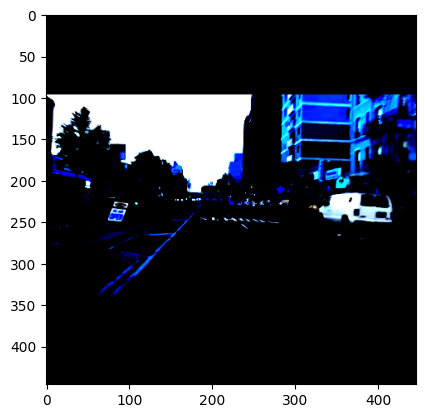

In [5]:
plt.imshow(test_img_batch[0].permute(1,2,0).detach().numpy())

In [6]:
from YOLOv1.utils import convert_labelgrid, decode_labelgrid

[d[3] for d in decode_labelgrid(train_label_grid_batch[0], 2, 13)]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


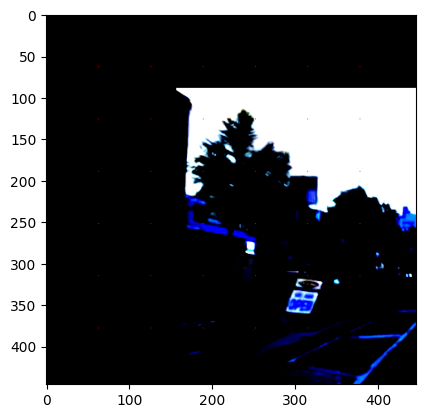

In [9]:


plt.imshow(visualize_gridbbox(train_img_batch[0], train_label_grid_batch[0]))

In [ ]:
visualize_gridbbox(img_batch[0], label_grid_batch[0])

In [ ]:
# visualize(transformed['image'], transformed['bboxes'], transformed['label'])
visualize(img, bboxes, labels)